
#                                                   THE POD-GALERKIN METHOD
 Script by Elise Grosjean (ENSTA-Paris, elise.grosjean@ensta-paris.fr)

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-fem

Let us consider a parameterized problem. Having (previously computed) solutions for different parameter values, we aim at approaching much faster the solution associated to a new parameter value.
The Galerkin-Proper Orthogonal Decomposition (POD) algorithm is decomposed in two parts: 
- The "offline part" : First we compute a reduced basis (denoted $\Phi_i$) from several snapshots of the solution (solutions for different parameter values in a parameter set $\mathcal{G}$),
- The "online part" : then we project onto it the solution associated to the new parameter value that we are interested in, denoted by $\mu \in \mathcal{G}$. To avoid computing the solution associated to this new parameter, we are going to solve instead a "reduced problem", that is the projection of the model onto the reduced space. This step is the key ingredient of the method: Instead of solving a problem of dimension the number of degrees of freedom, we are going to solve the reduced problem of dimension the number of functions in the reduced basis (also called modes). Thus, we assume here that this number can be much smaller than the number of degrees of freedom (see the paragraph on Kolmogorov n-width for details on this assumption) and that makes the algorithm runs much faster than the execution of usual high fidelity solver (e.g. FEM).


In [1]:
# import packages
import skfem  # for Finite Element Method
import numpy as np
import matplotlib.pyplot as plt 

## 1) The 2D-driven cavity problem:
#
We are going to use in this example the famous 2D-driven cavity problem with the Finite Element Method (FEM), which consists in 
solving on a unit square (denoted $\Omega$) the following equations:
\begin{align}
&-\nu \Delta u + (u \cdot \nabla) u + \nabla p =0, \textrm{ in } \Omega,\\
& \nabla. u=0, \textrm{ in } \Omega,\\
& (u_1,u_2)=(1,0), \textrm{ on } \Omega_{up}:=\partial \Omega \cap \{y=1\},\\
& (u_1,u_2)=(0,0), \textrm{ on } \partial \Omega \backslash \Omega_{up},
\end{align}
where $u=(u_1,u_2) \in V:=H^1_{d,0}(\Omega)^2=\{u \in H^1(\Omega)^2, \gamma_{\partial \Omega \backslash \Omega_{up}} u=0, \ \gamma_{up} u =(1,0) \}$ ($\gamma$ stands for the trace operator) represents the velocity of the incompressible fluid, $ p \in L^2(\Omega)$ its pressure, and $\nu=\frac{1}{Re}$ where $Re$ is the Reynolds parameter. Here, the Reynolds number is our parameter of interest ($\mu=Re$).
For the nonlinearity we adopt a fixed-point iteration scheme, and after multiplying by test functions $q$ and $v$ (resp. for pressure and velocity), which in variational form reads:
\begin{equation}
\nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k,v) -  (p^k, \nabla \cdot v) - (q, \nabla \cdot u^k) + 10^{-10} (p^k, q) =0, \textrm{in } \Omega,
\end{equation}
where $u^{k-1}$ is the previous step solution, and we iterate until a threshold is reached (until $\|u^{k}-u^{k-1}\| < \varepsilon $).
Here, with the term $ 10^{-10} (p^k, q)  $, we impose the average of the pressure $\int_{\Omega} p^k $ to be equal to $0$. For more details on how we derive this formulation, visit the link : https://github.com/grosjean1/navierStokes (FEM.pdf).

We employ Taylor-Hood elements to get a proper solution (e.g. P2-P1 for the tuple velocity-pressure) and obtain the system $\mathbf{K} \mathbf{x} =\mathbf{f}$ to solve where $\mathbf{K}= \begin{pmatrix}
\mathbf{A} & -\mathbf{B}^T\\
-\mathbf{B} & 10^{-10} \mathbf{C}
\end{pmatrix}$, $\mathbf{x}$ stands for the tuple velocity-pressure $(u_1^k,u_2^k,p^k)$, and where the assembled matrix $\mathbf{A}$ corresponds to the bilinear part $ \nu (\nabla u^k, \nabla v) + ((u^{k-1} \cdot \nabla) u^k),v) $, the matrix $ B$ to the bilinear part $(  p^k ,\nabla \cdot v)$ and $\mathbf{C}$ is the mass matrix applied to the pressure variable ($(\cdot,\cdot)$ represents either the $L^2$ inner-product onto the velocity space or onto the pressure space). 


The dirichlet boundary conditions are imposed with a penalization method, called with scikit-FEM by the line: 

solve(*condense(K,f, x=uvp, D=D)),

where x=uvp gives the values at the boundaries of the velocity and D refers to the boundary decomposition.





<skfem MeshTri1 object>
  Number of elements: 2048
  Number of vertices: 1089
  Number of nodes: 1089
  Named boundaries [# facets]: left [32], bottom [32], right [32], top [32], down [32], up [32]


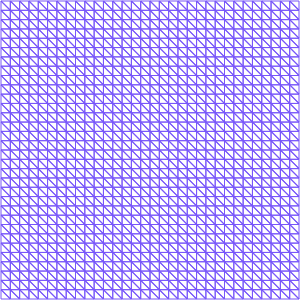

In [2]:
""" First we define a mesh for the unit square with the boundary decomposition """
mesh= skfem.MeshTri().refined(5).with_boundaries(
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

print(mesh)
mesh


In [3]:
""" Then we assemble the matrices of our model problem """

# Assembling matrices

from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import grad, dot,div,ddot

@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))

@BilinearForm
def vector_laplace(u, v, w):
    # same as laplace but for u,v vectors 
    return w.nu*ddot(grad(u), grad(v))

@BilinearForm
def mass(u, v, _):
    return u * v

@BilinearForm
def divu(u, v, w):
    return div(u) * v

@BilinearForm
def nonlinearterm(u, v, w):
    up_x, up_y = w.up 
    v_x,v_y=v[0],v[1]
    
    gradu=grad(u)
    gradxu_x=gradu[0,0] 
    gradxu_y=gradu[0,1]
    gradyu_x=gradu[1,0]
    gradyu_y=gradu[1,1]
    
    return (up_x*gradxu_x+up_y*gradxu_y)*v_x + (up_x*gradyu_x+up_y*gradyu_y)*v_y
    

In the 2D-driven cavity problem, the parameter of interest is the Reynolds number. In the code bellow, the function SolveCavityProblem(Re,Mesh) takes as parameters the Reynolds number and a mesh, and returns the associated solution (velocity-pressure).

In [4]:
""" Finally we solve the problem """
from skfem import *
# Compute solution of the 2d-driven cavity problem
element = {'u': ElementVector(ElementTriP2()),
           'p': ElementTriP1()} #[u,v,p]= velocity-pressure with Taylor-Hood P2-P1 FEM elements


def SolveCavityProblem(Re,Mesh):
    # Re is the reynolds parameter #
    Nu=1./Re 
    print('Parameter nu:',Nu)

    basis = {variable: Basis(Mesh, e, intorder=4)
         for variable, e in element.items()} # FEM space
    up=basis['u'].zeros() #initialization for non-linear term previous solution
    
    B =divu.assemble( basis['u'], basis['p']) # B.T=p*div(v) and B=q *div(u) with q=pressure test function
    C = mass.assemble(basis['p'],basis['p'] ) # 1^-10 * p*q impose pressure average equal to 0.
    A1 =vector_laplace.assemble(basis['u'],nu=Nu) # nu* grad(u) * grad(v) with u=[u1,u2] and v is test function v=[v1,v2]
    #A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up)) #(u^(k-1). grad u^k). v


    # global matrix Stokes
    K = bmat([[A1, -B.T],
          [-B, 1e-10 * C]], 'csr')

    def profil_up(x):
        """return u=(0,1) at the up boundary and (0,0) otherwise """
        return np.stack([x[1]==1, np.zeros_like(x[0])])
    
    up_basis = FacetBasis(Mesh, element['u'], facets=Mesh.boundaries['up'])
    all_basis = FacetBasis(Mesh, element['u'])

    uvp_boundary = np.hstack((
        all_basis.project(profil_up), # can be replaced by all_basis.project(profil_up), will be 0 by default for the other boundaries
        basis['p'].zeros(),
    ))

    D = basis['u'].get_dofs(['up', 'down', 'right','left']) # since we put D on basis['u'], there will be no penalization on pressure
    f = np.concatenate([basis['u'].zeros(),basis['p'].zeros()]) # =0

    #######################
    ### SOLVING PROBLEM ###
    #######################
    uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
    velocity, pressure = np.split(uvp, K.blocks)

    for i in range(15): #fixed-point iterations
        up=velocity.copy() # updating velocity
        A2=nonlinearterm.assemble(basis['u'],up=basis['u'].interpolate(up))

     
        # global matrix assembling update
        K = bmat([[A1+A2, -B.T],
          [-B, 1e-10 * C]], 'csr')

        uvp = solve(*condense(K,f, x=uvp_boundary, D=D))
     
        velocity, pressure = np.split(uvp, K.blocks)

    return velocity,pressure
    


Parameter nu: 0.006666666666666667


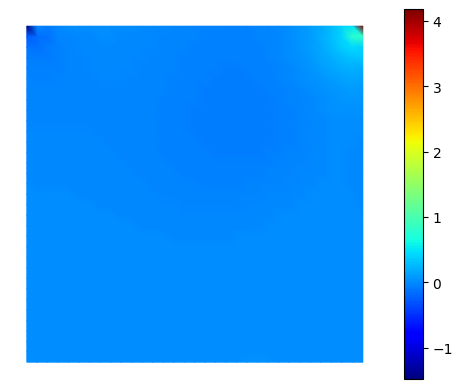

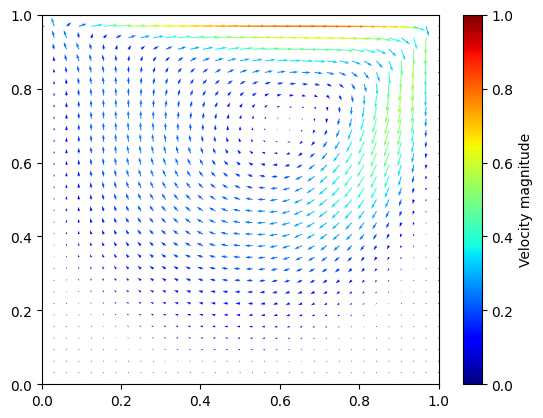

In [5]:
""" We may visualize the solutions """

from skfem.visuals.matplotlib import plot, draw, savefig

velocity,pressure=SolveCavityProblem(150,mesh) # example for Re=3

def visualize_pressure(Mesh,Pressure):
    ## Function that allows us to visualize the pressure
    #from skfem.visuals.matplotlib import plot
    return plot(Mesh, Pressure, shading='gouraud', colorbar=True)
    
visualize_pressure(mesh,pressure).show()

def visualize_velocity(Mesh,Velocity):
    ## Function that allows us to visualize the velocity
    fig, ax = plt.subplots()

    # Calculate the magnitude of velocity
    basis = {variable: Basis(Mesh, e, intorder=4)
            for variable, e in element.items()} # FEM space
    velocity1 = Velocity[basis['u'].nodal_dofs].copy()
    magnitude = np.sqrt(velocity1[0]**2 + velocity1[1]**2)

    # Display the velocity fields with colors for magnitude
    quiver = ax.quiver(*mesh.p, *velocity1, magnitude, angles='xy', cmap='jet')

    # colorbar
    cbar = plt.colorbar(quiver, ax=ax)

    # Limits of axis for the mesh
    ax.set_xlim([Mesh.p[0].min(), Mesh.p[0].max()])
    ax.set_ylim([Mesh.p[1].min(), Mesh.p[1].max()])
    cbar.set_label('Velocity magnitude')
    # show results
    plt.show()

visualize_velocity(mesh,velocity)

## 2) The POD-Galerkin method

We are now able to proceed with the offline and online parts of the POD-Galerkin method.


#### OFFLINE PART


We define one mesh and the associated finite element spaces (as before).

In [6]:
## FINE MESH
FineMesh = skfem.MeshTri().refined(5).with_boundaries(                                                                
        {                                                                                                                                
            "left": lambda x: x[0] == 0,                                                                                            
            "right": lambda x: x[0] == 1,            
            "down": lambda x: x[1] == 0,                                                                                            
            "up": lambda x: x[1] == 1,     
            
        }                                                                                                                               
)

FineBasis = {variable: Basis(FineMesh, e, intorder=4)
            for variable, e in element.items()} # FEM space

NumberOfNodesFineMesh = FineMesh.p.shape[1]
print("number of nodes: ",NumberOfNodesFineMesh)
#num_dofs_uFineMesh = basis['u'].doflocs.shape[1] # or np.shape(velocity)[0] for DOFs


number of nodes:  1089


For physical and mathematical reasons, we decompose the snapshots by one average over the parameters $\overline{u}$ and by one fluctuation part $u_f$. Then, the POD modes are estimated with the fluctuations following the steps detailed in the paragraph on the POD introduction.

In [7]:
""" POD """

print("-----------------------------------")
print("        Offline                    ")
print("-----------------------------------")

NumberOfSnapshots=10 #Training set
NumberOfModes=5 #tol

print("number of modes: ",NumberOfModes)

#####  Create fluctuation parts for the snapshots #####
Re=1. #first Reynolds number
AveragedSnapshots=FineBasis["u"].zeros()

FineSnapshots=[]
for i in range(NumberOfSnapshots):
    velocity,pressure=SolveCavityProblem(Re,FineMesh)
    print(Re)
    #visualize_velocity(mesh,velocity)
    AveragedSnapshots+=velocity
    FineSnapshots.append(velocity)
    
    Re+=45

print("last Reynolds:",Re)
AveragedSnapshots/=NumberOfSnapshots

for i in range(NumberOfSnapshots):
    FineSnapshots[i]-=AveragedSnapshots
    #visualize_velocity(FineMesh,FineSnapshots[i])

## SVD ##
@BilinearForm
def massVelocity(u, v, _):
    return u[0] * v[0]+u[1] * v[1]
    
L2=massVelocity.assemble(FineBasis["u"])
# We first compute the correlation matrix C_ij = (u_i,u_j)
CorrelationMatrix = np.zeros((NumberOfSnapshots, NumberOfSnapshots))
for i, snapshot1 in enumerate(FineSnapshots):
    MatVecProduct = L2.dot(snapshot1)
    for j, snapshot2 in enumerate(FineSnapshots):
        if i >= j:
            CorrelationMatrix[i, j] = np.dot(MatVecProduct, snapshot2)
            CorrelationMatrix[j, i] = CorrelationMatrix[i, j]

#print("CorrelationMatrix",CorrelationMatrix)
# Then, we compute the eigenvalues/eigenvectors of C 
EigenValues, EigenVectors = np.linalg.eigh(CorrelationMatrix, UPLO="L") #SVD: C eigenVectors=eigenValues eigenVectors
idx = EigenValues.argsort()[::-1] # sort the eigenvalues

TotEigenValues = EigenValues[idx]
TotEigenVectors = EigenVectors[:, idx]
EigenValues=TotEigenValues[0:NumberOfModes]
EigenVectors=TotEigenVectors[:,0:NumberOfModes]

print("eigenvalues: ",EigenValues)

RIC=1-np.sum(EigenValues)/np.sum(TotEigenValues) #must be close to 0
print("Relativ Information Content (must be close to 0):",RIC)
RIClist=[]
for i in range(len(EigenValues)):
    RIClist.append(1-np.sum(EigenValues[:i])/np.sum(TotEigenValues)) #must be close to 0


ChangeOfBasisMatrix = np.zeros((NumberOfModes,NumberOfSnapshots))

for j in range(NumberOfModes):
    ChangeOfBasisMatrix[j,:] = EigenVectors[:,j]/np.sqrt(EigenValues[j])

ReducedBasis = np.dot(ChangeOfBasisMatrix,FineSnapshots)


#visualize_velocity(mesh,ReducedBasis[2])

# orthogonality test
#for i in range(NumberOfModes):
#    MatVecProduct = L2.dot(ReducedBasis[i])
#    for j in range(NumberOfModes):    
#        test = np.dot(MatVecProduct, ReducedBasis[j])
#        print("orthogonal:",test)

-----------------------------------
        Offline                    
-----------------------------------
number of modes:  5
Parameter nu: 1.0
1.0
Parameter nu: 0.021739130434782608
46.0
Parameter nu: 0.01098901098901099
91.0
Parameter nu: 0.007352941176470588
136.0
Parameter nu: 0.0055248618784530384
181.0
Parameter nu: 0.004424778761061947
226.0
Parameter nu: 0.0036900369003690036
271.0
Parameter nu: 0.0031645569620253164
316.0
Parameter nu: 0.002770083102493075
361.0
Parameter nu: 0.0024630541871921183
406.0
last Reynolds: 451.0
eigenvalues:  [2.54755393e-02 3.20763587e-03 2.74529238e-04 2.30847869e-05
 2.67682655e-06]
Relativ Information Content (must be close to 0): 6.990652706928557e-06


Having reduced bases $(\Phi_i)_{i=1,\dots,N}$ for the velocity and $(\Psi_i)_{i=1,\dots,N}$ for the pressure, we may complete the offline part by assembling the new matrices of our problem: 

Instead of using $(u,p)$ in our scheme as before
\begin{equation}
\nu (\nabla u, \nabla v) + ((u \cdot \nabla) u,v) -  (p, \nabla \cdot v) - (q, \nabla \cdot u) + 10^{-10} (p, q) =0, \textrm{in } \Omega,
\end{equation} we are going to replace them by $(\overline{u}+ \sum_{j=1}^N \alpha^k_j \Phi_j,\overline{p} + \sum_{j=1}^N \beta^k_j \Psi_j)$ and $(v,q)$ by $(\Phi_i,\Psi_i)$. Thus, we get:

\begin{align}
& \nu (\nabla \overline{u}, \nabla \Phi_i) + \nu ( \sum_{j=1}^N \alpha^k_j \nabla \Phi_j, \nabla \Phi_i)\\
& \quad \quad \quad + (\overline{u} \cdot  \nabla \overline{u},\Phi_i)  + (\overline{u} \cdot \sum_{j=1}^N \alpha^k_j \nabla \Phi_j,\Phi_i) + (\sum_{j=1}^N \alpha^{k}_j \Phi_j \cdot \nabla \overline{u},\Phi_i) + (\sum_{r=1}^N \alpha^{k-1}_r \Phi_r \cdot \sum_{j=1}^N \alpha^k_j \nabla \Phi_j,\Phi_i) \\
& \quad \quad \quad -  (\overline{p}, \nabla \cdot \Phi_i) -  (\sum_{j=1}^N \beta^k_j  \Psi_j, \nabla \cdot \Phi_i)- (\Psi_i, \nabla \cdot \overline{u}) - (\Psi_i, \sum_{j=1}^N \alpha^k_j \nabla \cdot \Phi_j) + 10^{-10} (\overline{p}, \Psi_i) + 10^{-10} (\sum_{j=1}^N \beta^k_j  \Psi_j, \Psi_i) =0, \textrm{in } \Omega.
\end{align}
Since $\nabla \cdot u^k=0$, the reduced basis functions $(\Phi_i)_{i=1,\dots,N}$ belongs to $V^N \subset V_{div}:=\{v \in V, \nabla \cdot v=0\}$ and $(\Psi_i)_{i=1,\dots,N}$ is of average equal to $0$. Therefore it gives 
\begin{equation}
 \nu (\nabla \overline{u}, \nabla \Phi_i) + \nu \sum_{j=1}^N \alpha^k_j ( \nabla \Phi_j, \nabla \Phi_i)+(\overline{u} \cdot  \nabla \overline{u},\Phi_i) + \sum_{j=1}^N \alpha^k_j (\overline{u} \cdot \nabla \Phi_j,\Phi_i) + \sum_{j=1}^N \alpha^{k}_j ( \Phi_j \cdot \nabla \overline{u},\Phi_i) + \sum_{j=1}^N \sum_{r=1}^N \alpha^k_j \alpha^{k-1}_r  (\Phi_r \cdot  \nabla \Phi_j,\Phi_i) =0, \textrm{in } \Omega.
\end{equation}
We remark that we do not need to generate the reduced basis for the pressure, and that we obtain three kinds of terms:

- the ones that do not depend on the coefficients $\alpha$,
- the ones that depend on the coefficients $\alpha^k$,
- and one term that depends on the $\alpha^k$ and on the $\alpha^{k-1}$.


Therefore, we shall regroup these terms such that we get:
\begin{equation}
\mathcal{A}_i + \sum_{j=1}^N \mathcal{B}_{ij} \alpha^k_j + \sum_{j=1}^N \sum_{r=1}^N \mathcal{C}_{ijr} \alpha^k_j \alpha^{k-1}_r =0,
\end{equation}
where 
\begin{equation}
\mathcal{A}_i = \underbrace{\nu (\nabla \overline{u}, \nabla \Phi_i)}_{A1} + \underbrace{(\overline{u} \cdot  \nabla \overline{u},\Phi_i)}_{A2}, \textrm { and } \mathcal{B}_{ij} =  \underbrace{\nu ( \nabla \Phi_j, \nabla \Phi_i)}_{B1} + \underbrace{(\overline{u} \cdot \nabla \Phi_j,\Phi_i)}_{B2} + \underbrace{( \Phi_j \cdot \nabla \overline{u},\Phi_i)}_{B3} \textrm{ and }\mathcal{C}_{ijr} =( \Phi_r \cdot  \nabla \Phi_j,\Phi_i).
\end{equation}

In [8]:
print("---------------------------------------")
print("---- OFFLINE PART: BUILDING MATRICES --")
print("---------------------------------------")
############################
## Assembling \mathcal{A} ##
############################
@LinearForm
def A1(v,w):
    # First term in \mathcal{A}_i
    return ddot(grad(w.up), grad(v))

A1Mat=A1.assemble(FineBasis["u"],up=FineBasis['u'].interpolate(AveragedSnapshots))

@LinearForm
def A2(v, w):
    # Second term in \mathcal{A}_i
    u_x, u_y = w.up[0],w.up[1]
    v_x,v_y=v[0],v[1]
    
    gradu=grad(w.up)
    gradxu_x=gradu[0,0] 
    gradxu_y=gradu[0,1]
    gradyu_x=gradu[1,0]
    gradyu_y=gradu[1,1]
    
    return (u_x*gradxu_x+u_y*gradxu_y)*v_x + (u_x*gradyu_x+u_y*gradyu_y)*v_y

A2Mat=A2.assemble(FineBasis["u"],up=FineBasis['u'].interpolate(AveragedSnapshots))


############################
## Assembling \mathcal{B} ##
############################
@BilinearForm
def B1(u, v, _):
    # same as laplace but for u,v vectors  (\nabla \Phi_i,\nabla \Phi_j)
    # First term in \mathcal{B}_ij (without \nu)
    return ddot(grad(u), grad(v))

B1Mat=B1.assemble(FineBasis["u"])


@LinearForm
def nonlinearterms(v, w):
    # Other terms in \mathcal{B}_ij and \mathcal{C}
    v_x,v_y=w.Phii[0],w.Phii[1]
    u_x, u_y = w.Phik[0],w.Phik[1]
    gradu=grad(w.Phij)

    gradxu_x=gradu[0,0] 
    gradxu_y=gradu[0,1]
    gradyu_x=gradu[1,0]
    gradyu_y=gradu[1,1]
    
    return ((u_x*gradxu_x+u_y*gradxu_y)*(v_x*v[0]) + (u_x*gradyu_x+u_y*gradyu_y)*(v_y*v[1]) ) 

#############################################
## Project matrices onto the reduced space ##
#############################################

A1reduced = np.zeros(NumberOfModes)
A2reduced = np.zeros(NumberOfModes)
B1reduced = np.zeros((NumberOfModes, NumberOfModes))
B2reduced = np.zeros((NumberOfModes, NumberOfModes))
B3reduced = np.zeros((NumberOfModes, NumberOfModes))
Creduced = np.zeros((NumberOfModes, NumberOfModes**2))

for i in range(NumberOfModes):
    A1reduced[i]=np.dot(A1Mat,ReducedBasis[i]) 
    A2reduced[i]=np.dot(A2Mat,ReducedBasis[i]) 

for i in range(NumberOfModes):
    MatB1VecProduct = B1Mat.dot(ReducedBasis[i])
    
    for j in range(NumberOfModes):
        if j>=i:
            B1reduced[i,j] = np.dot(MatB1VecProduct, ReducedBasis[j])
            B1reduced[j,i] = B1reduced[i,j]
            
        B2Vect=nonlinearterms.assemble(FineBasis["u"],Phii=FineBasis['u'].interpolate(ReducedBasis[i]),Phij=FineBasis['u'].interpolate(ReducedBasis[j]),Phik=FineBasis['u'].interpolate(AveragedSnapshots))
        B3Vect=nonlinearterms.assemble(FineBasis["u"],Phii=FineBasis['u'].interpolate(ReducedBasis[i]),Phij=FineBasis['u'].interpolate(AveragedSnapshots),Phik=FineBasis['u'].interpolate(ReducedBasis[j]))

        B2reduced[i,j] = np.sum(B2Vect) 
        B3reduced[i,j] = np.sum(B3Vect)       
        
        for r in range(NumberOfModes):
            CVect=nonlinearterms.assemble(FineBasis["u"],Phii=FineBasis['u'].interpolate(ReducedBasis[i]),Phij=FineBasis['u'].interpolate(ReducedBasis[j]),Phik=FineBasis['u'].interpolate(ReducedBasis[r]))
            Creduced[i,j*NumberOfModes+r] = np.sum(CVect)
            


---------------------------------------
---- OFFLINE PART: BUILDING MATRICES --
---------------------------------------


Now we can proceed with the online step and solve the reduced system!

-----------------------------------
        ONLINE PART !!!            
-----------------------------------
residual 0.81454380623126
residual 0.6508667958193831
residual 0.5077311655547908
residual 0.41774140111619057
residual 0.34914138794027705
residual 0.25882188307646603
residual 0.23472034493949842
residual 0.1774531936821554
residual 0.1554449810324393
residual 0.12537300440470994
residual 0.10065564574682839
residual 0.08464097168355579
residual 4.656612873077393e-10


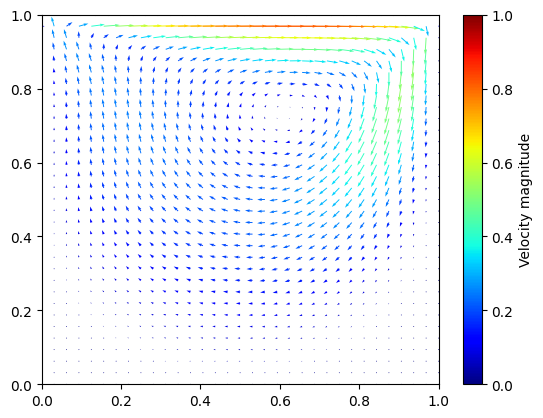

In [9]:
print("-----------------------------------")
print("        ONLINE PART !!!            ")
print("-----------------------------------")
# solve reduced system #
Ret=106.0 # New targeted parameter !
nu=1./Ret;

Alphak=np.zeros(NumberOfModes)
AlphakPrec=np.zeros(NumberOfModes) 

for k in range(20):
    residual=0.
    GlobalReducedMatrix=np.zeros((NumberOfModes,NumberOfModes))
    GlobalReducedA=np.zeros(NumberOfModes)
    for i in range(NumberOfModes):
        for j in range(NumberOfModes):
            GlobalReducedMatrix[i,j]=nu*B1reduced[i,j]+B2reduced[i,j]+B3reduced[i,j]
            for r in range(NumberOfModes):
                GlobalReducedMatrix[i,j]+=Creduced[i,j*NumberOfModes+r]*AlphakPrec[r]
        GlobalReducedA[i]=-nu*A1reduced[i]-A2reduced[i]
    #print(GlobalReducedMatrix)
    #print(GlobalReducedA)
    Alphak=np.linalg.solve(GlobalReducedMatrix,GlobalReducedA) #coefficients
    
    #print(Alphak)
    
    for ii in range(NumberOfModes):
        residual+=(Alphak[ii]-AlphakPrec[ii])**2
        residual=np.sqrt(residual);
    if residual<1e-6: # stop when tolerance is retrieved
        print("residual",residual)#
        break
    print("residual",residual)#
    AlphakPrec=Alphak.copy()

uRebuilt = np.dot(Alphak, ReducedBasis) #u^N(x,nu) = sum_i alpha(nu) Phi_i(x)
uRebuilt+=AveragedSnapshots # adding the average

visualize_velocity(mesh,uRebuilt)


In [11]:
print("------------------------------------")
print("       Approximation accuracy       ")
print("------------------------------------")
### Online Errors
print("Online Errors")

ExactSolution,pressure=SolveCavityProblem(Ret,FineMesh) # Exact solution for the new targeted parameter
print("Reynolds: " , Ret)

H10=vector_laplace.assemble(FineBasis['u'],nu=1)

velocity=ExactSolution.copy()
velocity-=AveragedSnapshots
TrueAlpha=velocity@(L2@ReducedBasis.transpose()) # True projection (projection of the fine solution onto the RB)
print("true coefficients:",TrueAlpha)
print("POD-Galerkin coefficients:", Alphak)

TrueCompressedSolution = np.dot(TrueAlpha, ReducedBasis) 
ReconstructedCompressedSolution = np.dot(Alphak, ReducedBasis) 

TrueCompressedSolution+=AveragedSnapshots
ReconstructedCompressedSolution+=AveragedSnapshots #ReconstructedCompressedSolution = uRebuilt
    
norml2ExactSolution=np.sqrt(ExactSolution@(L2@ExactSolution)) # for relative errors
normh10ExactSolution=np.sqrt(ExactSolution@(H10@ExactSolution))

AbsErrRec=np.abs(ReconstructedCompressedSolution-ExactSolution)
AbsErrTrue=np.abs(TrueCompressedSolution-ExactSolution)

if norml2ExactSolution !=0 and normh10ExactSolution != 0:

    L2RelError=np.sqrt(AbsErrRec@L2@AbsErrRec)/norml2ExactSolution
    H10RelError=np.sqrt(AbsErrRec@H10@AbsErrRec)/normh10ExactSolution

    TrueL2RelError=np.sqrt(AbsErrTrue@L2@AbsErrTrue)/norml2ExactSolution
    TrueH10RelError=np.sqrt(AbsErrTrue@H10@AbsErrTrue)/normh10ExactSolution
    
else:
    L2RelError = np.linalg.norm(ReconstructedCompressedSolution-ExactSolution)
    TrueL2RelError = np.linalg.norm(TrueCompressedSolution-ExactSolution)
    
print("L2 compression relative error with true coefficients = ", TrueL2RelError)
print("H1 compression relative error with true coefficients = ", TrueH10RelError)
print("Online L2 compression relative error = ", L2RelError)
print("Online H1 compression relative error = ", H10RelError)


------------------------------------
       Approximation accuracy       
------------------------------------
Online Errors
Parameter nu: 0.009433962264150943
Reynolds:  106.0
true coefficients: [-0.03820889  0.02000933  0.00602844 -0.00069321  0.00083005]
POD-Galerkin coefficients: [-0.03816935  0.02001844  0.00601413 -0.00068576  0.00077342]
L2 compression relative error with true coefficients =  0.0003640043027066953
H1 compression relative error with true coefficients =  0.0004519958605203538
Online L2 compression relative error =  0.00045574044329428794
Online H1 compression relative error =  0.0004416712899857957
